In [1]:
!pip install tqdm

from tqdm import tqdm
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from PIL import Image
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
tf.set_random_seed(10)
np.random.seed(10)

In [3]:

df = pd.read_csv('https://github.com/harveenchadha/dump-nn-tf/raw/master/Section2/NN_Predict_Fraud/train.csv')
df.dropna(inplace=True)
iris = tf.contrib.learn.datasets.load_iris()

scl = StandardScaler()

Instructions for updating:
Use scikits.learn.datasets.
Instructions for updating:
Use tf.data instead.


In [0]:
def WeightsVariable(shape, name = 'weights'):
    return tf.Variable(tf.truncated_normal(shape, mean = 0.0, stddev=0.001, name=name))

def BiasVariable(shape, name = 'biases'):
    return tf.Variable(tf.constant(1.0, shape=[shape], name='biases'))

In [0]:
def network(images, channels = 1, input_shape = 4, output_shape = 3):
    num_c = [input_shape, 256, 128, 64, 32, 16, 8, 4, output_shape]
    num_i = 1
    with tf.name_scope('fc1'):
        weights = WeightsVariable([input_shape, num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    num_i += 1
    with tf.name_scope('fc2'):
        weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
    num_i += 1    
    with tf.name_scope('fc3'):
        weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
    num_i += 1    
    with tf.name_scope('fc5'):
        weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
    num_i += 1    
    with tf.name_scope('fc6'):
        weights = WeightsVariable([num_c[num_i - 1], num_c[num_i]])
        biases = BiasVariable(num_c[num_i])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)   
    num_i += 1
    with tf.name_scope('fc4'):
        weights = WeightsVariable([num_c[num_i - 1], output_shape])
        biases = BiasVariable(output_shape)
        fc2 = tf.matmul(fc1, weights) + biases
    return fc2

In [0]:
def loss_metrics(logits, labels, output_shape=1):
    logits = logits
    if output_shape == 1:
      cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
      
    else:
      cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
    return tf.reduce_mean(cross_entropy, name = 'softmax_mean')

In [0]:
#returns the optimizer by taking the loss
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate = STARTER_LR)
    train_op = optimizer.minimize(loss)
    return train_op
    

In [0]:
def evaluation(logits, labels, output_shape = 1):
    correct = tf.nn.in_top_k(logits, labels, k = 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))#, accuracy1, accuracy2
  
def acc(logits, labels, output_shape = 1):
  
    if(output_shape == 1):
        correct_prediction = tf.equal(tf.cast(tf.greater_equal(logits,0.5), tf.float32), tf.cast(labels, tf.float32))
        
    else:
        correct_prediction = tf.equal(tf.argmax(logits, 1),  tf.cast(labels, tf.int64), name='correct_pred')
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

In [0]:
def placeholder_inputs(batch_size, input_shape=None, output_shape=1):
    image_placeholder = tf.placeholder(tf.float32, shape = (None, input_shape))
    if output_shape == 1:
      label_placeholder = tf.placeholder(tf.float32, shape = (None))
    else:
      label_placeholder = tf.placeholder(tf.int32, shape = (None))
    return image_placeholder, label_placeholder

In [0]:

loss_plot = []
acc_plot = []
train_plot = []
def run_training(x, y, input_shape=None, output_shape=1):
  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    with tf.Graph().as_default():

        images_pl, labels_pl = placeholder_inputs(BATCH_SIZE, input_shape=input_shape, output_shape = output_shape)
        logits = network(images_pl, input_shape=input_shape, output_shape=output_shape)
        
        print("Logits Calculated Successfully")
        loss = loss_metrics(logits = logits, labels = labels_pl, output_shape = output_shape)
        train_op = training(loss)
#         eval_correct = evaluation(logits, labels_pl)
        acc_val = acc(logits, labels_pl, output_shape = output_shape)
        summary = tf.summary.merge_all()
        
        init = tf.global_variables_initializer()
        
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) #OPTIONAL
        sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))
        
        saver = tf.train.Saver()
        sess.run(init)
        for steps in range(MAX_STEPS):
            loss_avg = []
            for i in tqdm(np.arange(0, len(x_train), BATCH_SIZE)):
                images_feed = x_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]
                labels_feed = y_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]

                feed_dict = { images_pl: images_feed, labels_pl: labels_feed }

                _ = sess.run([train_op], feed_dict = feed_dict)
                

            images_feed = x_test
            labels_feed = y_test

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            loss_  = sess.run([loss], feed_dict = feed_dict)
            accuracy_val  = sess.run([acc_val], feed_dict = feed_dict)
            images_feed = x_train
            labels_feed = y_train

            feed_dict = {
                images_pl: images_feed,
                labels_pl: labels_feed
                        }
            train_loss  = sess.run([loss], feed_dict = feed_dict)
            
            loss_plot.append(loss_)
            train_plot.append(train_loss)
            acc_plot.append(accuracy_val)
            print('Loss %d: Training loss = %.5f  Validation loss = %.5f\t Validation Acc = %.5f' % (steps+1, train_loss[0], loss_[0], accuracy_val[0]))     
          
        return sess, images_pl, labels_pl, acc_val, logits

In [0]:

# x = iris[0]
# y = iris[1]

x = df.iloc[:, :30]
y = df.iloc[:, -1:]


x = scl.fit_transform(x)

STARTER_LR = 6e-5
BATCH_SIZE = 2
MAX_STEPS = 200

loss_plot = []
acc_plot = []
train_plot = []
sess, images_pl, labels_pl, eval_correct, logits = run_training(np.asarray(x, dtype = np.float32), np.asarray(y, dtype = np.float32), input_shape=x.shape[1], output_shape=y.shape[1])

Logits Calculated Successfully


 20%|█▉        | 62/315 [00:00<00:00, 603.30it/s]

Loss 1: Training loss = 0.66877  Validation loss = 0.67641	 Validation Acc = 0.49259


 20%|██        | 63/315 [00:00<00:00, 629.98it/s]

Loss 2: Training loss = 0.63185  Validation loss = 0.64841	 Validation Acc = 0.49259


 20%|██        | 63/315 [00:00<00:00, 626.41it/s]

Loss 3: Training loss = 0.59683  Validation loss = 0.61648	 Validation Acc = 0.49259


 20%|██        | 63/315 [00:00<00:00, 627.67it/s]

Loss 4: Training loss = 0.56769  Validation loss = 0.58993	 Validation Acc = 0.60741


 20%|█▉        | 62/315 [00:00<00:00, 615.87it/s]

Loss 5: Training loss = 0.54292  Validation loss = 0.56610	 Validation Acc = 0.61481


 20%|██        | 64/315 [00:00<00:00, 624.72it/s]

Loss 6: Training loss = 0.52233  Validation loss = 0.54572	 Validation Acc = 0.62963


 20%|██        | 64/315 [00:00<00:00, 626.09it/s]

Loss 7: Training loss = 0.50509  Validation loss = 0.52844	 Validation Acc = 0.65185


 20%|██        | 63/315 [00:00<00:00, 623.91it/s]

Loss 8: Training loss = 0.48991  Validation loss = 0.51331	 Validation Acc = 0.66667


 20%|██        | 64/315 [00:00<00:00, 627.22it/s]

Loss 9: Training loss = 0.47695  Validation loss = 0.50038	 Validation Acc = 0.68889


 20%|██        | 64/315 [00:00<00:00, 626.43it/s]

Loss 10: Training loss = 0.46608  Validation loss = 0.48924	 Validation Acc = 0.70370


 20%|██        | 64/315 [00:00<00:00, 623.86it/s]

Loss 11: Training loss = 0.45626  Validation loss = 0.47931	 Validation Acc = 0.71111


 21%|██        | 65/315 [00:00<00:00, 644.92it/s]

Loss 12: Training loss = 0.44738  Validation loss = 0.47057	 Validation Acc = 0.71852


 20%|██        | 63/315 [00:00<00:00, 622.22it/s]

Loss 13: Training loss = 0.43926  Validation loss = 0.46257	 Validation Acc = 0.72593


 20%|██        | 64/315 [00:00<00:00, 627.04it/s]

Loss 14: Training loss = 0.43178  Validation loss = 0.45521	 Validation Acc = 0.72963


 20%|██        | 63/315 [00:00<00:00, 627.63it/s]

Loss 15: Training loss = 0.42478  Validation loss = 0.44837	 Validation Acc = 0.73333


 20%|██        | 64/315 [00:00<00:00, 632.22it/s]

Loss 16: Training loss = 0.41814  Validation loss = 0.44194	 Validation Acc = 0.73704


 20%|██        | 63/315 [00:00<00:00, 628.86it/s]

Loss 17: Training loss = 0.41186  Validation loss = 0.43592	 Validation Acc = 0.74815


 20%|██        | 64/315 [00:00<00:00, 630.51it/s]

Loss 18: Training loss = 0.40615  Validation loss = 0.43025	 Validation Acc = 0.75556


 20%|██        | 64/315 [00:00<00:00, 636.45it/s]

Loss 19: Training loss = 0.40070  Validation loss = 0.42473	 Validation Acc = 0.75926


 20%|██        | 63/315 [00:00<00:00, 614.46it/s]

Loss 20: Training loss = 0.39536  Validation loss = 0.41934	 Validation Acc = 0.78148


 20%|██        | 64/315 [00:00<00:00, 629.90it/s]

Loss 21: Training loss = 0.39033  Validation loss = 0.41430	 Validation Acc = 0.78519


 20%|██        | 64/315 [00:00<00:00, 627.30it/s]

Loss 22: Training loss = 0.38536  Validation loss = 0.40937	 Validation Acc = 0.78519


 21%|██        | 65/315 [00:00<00:00, 640.18it/s]

Loss 23: Training loss = 0.37965  Validation loss = 0.40370	 Validation Acc = 0.80000


 20%|██        | 64/315 [00:00<00:00, 630.51it/s]

Loss 24: Training loss = 0.37441  Validation loss = 0.39857	 Validation Acc = 0.80741


 20%|██        | 64/315 [00:00<00:00, 637.55it/s]

Loss 25: Training loss = 0.36444  Validation loss = 0.38817	 Validation Acc = 0.81481


 21%|██        | 65/315 [00:00<00:00, 636.47it/s]

Loss 26: Training loss = 0.36217  Validation loss = 0.38650	 Validation Acc = 0.82222


 20%|██        | 64/315 [00:00<00:00, 636.62it/s]

Loss 27: Training loss = 0.35030  Validation loss = 0.37430	 Validation Acc = 0.82222


 20%|██        | 64/315 [00:00<00:00, 629.16it/s]

Loss 28: Training loss = 0.34768  Validation loss = 0.37223	 Validation Acc = 0.82222


 20%|██        | 64/315 [00:00<00:00, 629.48it/s]

Loss 29: Training loss = 0.34202  Validation loss = 0.36686	 Validation Acc = 0.82593


 20%|██        | 64/315 [00:00<00:00, 627.90it/s]

Loss 30: Training loss = 0.33431  Validation loss = 0.35943	 Validation Acc = 0.83333


 20%|██        | 64/315 [00:00<00:00, 635.83it/s]

Loss 31: Training loss = 0.32905  Validation loss = 0.35480	 Validation Acc = 0.83704


 20%|██        | 63/315 [00:00<00:00, 623.11it/s]

Loss 32: Training loss = 0.31946  Validation loss = 0.34563	 Validation Acc = 0.83333


 20%|██        | 64/315 [00:00<00:00, 633.57it/s]

Loss 33: Training loss = 0.32251  Validation loss = 0.35007	 Validation Acc = 0.83333


 20%|██        | 64/315 [00:00<00:00, 625.56it/s]

Loss 34: Training loss = 0.30283  Validation loss = 0.33053	 Validation Acc = 0.84074


 21%|██        | 65/315 [00:00<00:00, 635.30it/s]

Loss 35: Training loss = 0.29948  Validation loss = 0.32853	 Validation Acc = 0.84815


 20%|██        | 64/315 [00:00<00:00, 631.64it/s]

Loss 36: Training loss = 0.29228  Validation loss = 0.32228	 Validation Acc = 0.85185


 20%|██        | 64/315 [00:00<00:00, 636.27it/s]

Loss 37: Training loss = 0.28827  Validation loss = 0.31984	 Validation Acc = 0.85556


 20%|██        | 64/315 [00:00<00:00, 630.69it/s]

Loss 38: Training loss = 0.28182  Validation loss = 0.31465	 Validation Acc = 0.85556


 20%|██        | 64/315 [00:00<00:00, 630.87it/s]

Loss 39: Training loss = 0.27741  Validation loss = 0.31158	 Validation Acc = 0.85556


 20%|██        | 64/315 [00:00<00:00, 634.74it/s]

Loss 40: Training loss = 0.27198  Validation loss = 0.30716	 Validation Acc = 0.85926


 20%|██        | 63/315 [00:00<00:00, 629.02it/s]

Loss 41: Training loss = 0.26302  Validation loss = 0.29888	 Validation Acc = 0.86296


 20%|██        | 63/315 [00:00<00:00, 621.45it/s]

Loss 42: Training loss = 0.25915  Validation loss = 0.29640	 Validation Acc = 0.86296


 21%|██        | 65/315 [00:00<00:00, 644.07it/s]

Loss 43: Training loss = 0.25394  Validation loss = 0.29240	 Validation Acc = 0.86296


 20%|██        | 64/315 [00:00<00:00, 631.93it/s]

Loss 44: Training loss = 0.24690  Validation loss = 0.28632	 Validation Acc = 0.87037


 21%|██        | 65/315 [00:00<00:00, 643.08it/s]

Loss 45: Training loss = 0.24451  Validation loss = 0.28515	 Validation Acc = 0.87037


 21%|██        | 65/315 [00:00<00:00, 643.58it/s]

Loss 46: Training loss = 0.23685  Validation loss = 0.27820	 Validation Acc = 0.87778


 20%|██        | 63/315 [00:00<00:00, 620.99it/s]

Loss 47: Training loss = 0.23309  Validation loss = 0.27548	 Validation Acc = 0.87778


 20%|██        | 64/315 [00:00<00:00, 635.65it/s]

Loss 48: Training loss = 0.22956  Validation loss = 0.27298	 Validation Acc = 0.88519


 20%|██        | 64/315 [00:00<00:00, 631.42it/s]

Loss 49: Training loss = 0.22608  Validation loss = 0.27044	 Validation Acc = 0.89259


 20%|█▉        | 62/315 [00:00<00:00, 618.72it/s]

Loss 50: Training loss = 0.22280  Validation loss = 0.26812	 Validation Acc = 0.89259


 20%|██        | 63/315 [00:00<00:00, 616.92it/s]

Loss 51: Training loss = 0.22018  Validation loss = 0.26633	 Validation Acc = 0.89259


 20%|██        | 64/315 [00:00<00:00, 628.50it/s]

Loss 52: Training loss = 0.21752  Validation loss = 0.26440	 Validation Acc = 0.89259


 21%|██        | 65/315 [00:00<00:00, 642.14it/s]

Loss 53: Training loss = 0.21495  Validation loss = 0.26247	 Validation Acc = 0.89630


 20%|██        | 63/315 [00:00<00:00, 615.25it/s]

Loss 54: Training loss = 0.21278  Validation loss = 0.26087	 Validation Acc = 0.90000


 20%|██        | 64/315 [00:00<00:00, 632.27it/s]

Loss 55: Training loss = 0.21066  Validation loss = 0.25932	 Validation Acc = 0.90000


 20%|██        | 64/315 [00:00<00:00, 638.00it/s]

Loss 56: Training loss = 0.20895  Validation loss = 0.25817	 Validation Acc = 0.90000


 20%|██        | 64/315 [00:00<00:00, 636.83it/s]

Loss 57: Training loss = 0.20666  Validation loss = 0.25645	 Validation Acc = 0.90000


 20%|██        | 64/315 [00:00<00:00, 625.96it/s]

Loss 58: Training loss = 0.20532  Validation loss = 0.25563	 Validation Acc = 0.90000


 20%|██        | 64/315 [00:00<00:00, 625.44it/s]

Loss 59: Training loss = 0.20375  Validation loss = 0.25463	 Validation Acc = 0.89630


 20%|██        | 64/315 [00:00<00:00, 629.93it/s]

Loss 60: Training loss = 0.20233  Validation loss = 0.25387	 Validation Acc = 0.90370


 21%|██        | 65/315 [00:00<00:00, 637.65it/s]

Loss 61: Training loss = 0.20062  Validation loss = 0.25278	 Validation Acc = 0.90370


 20%|██        | 64/315 [00:00<00:00, 626.00it/s]

Loss 62: Training loss = 0.19904  Validation loss = 0.25174	 Validation Acc = 0.90370


 20%|██        | 64/315 [00:00<00:00, 630.63it/s]

Loss 63: Training loss = 0.19743  Validation loss = 0.25064	 Validation Acc = 0.90370


 20%|██        | 64/315 [00:00<00:00, 626.37it/s]

Loss 64: Training loss = 0.19595  Validation loss = 0.24965	 Validation Acc = 0.90370


 20%|██        | 64/315 [00:00<00:00, 628.76it/s]

Loss 65: Training loss = 0.19498  Validation loss = 0.24911	 Validation Acc = 0.90370


 20%|█▉        | 62/315 [00:00<00:00, 612.48it/s]

Loss 66: Training loss = 0.19405  Validation loss = 0.24861	 Validation Acc = 0.90370


 21%|██        | 65/315 [00:00<00:00, 643.80it/s]

Loss 67: Training loss = 0.19290  Validation loss = 0.24795	 Validation Acc = 0.90370


 20%|██        | 64/315 [00:00<00:00, 628.72it/s]

Loss 68: Training loss = 0.19270  Validation loss = 0.24809	 Validation Acc = 0.90370


 20%|██        | 64/315 [00:00<00:00, 630.79it/s]

Loss 69: Training loss = 0.19097  Validation loss = 0.24688	 Validation Acc = 0.90370


 20%|██        | 64/315 [00:00<00:00, 634.83it/s]

Loss 70: Training loss = 0.18958  Validation loss = 0.24598	 Validation Acc = 0.90370


  0%|          | 0/315 [00:00<?, ?it/s]

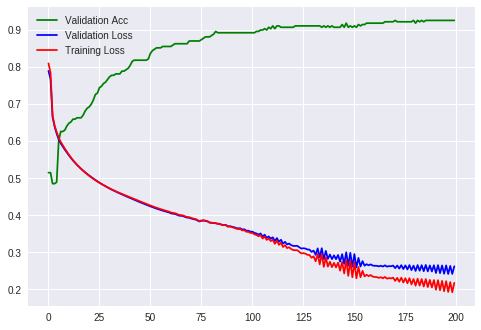

In [17]:
sns.set_style("darkgrid")
plt.plot(acc_plot,'g-',label="Validation Acc")
plt.plot(loss_plot, 'b-', label="Validation Loss")
plt.plot(train_plot, "r-", label='Training Loss')
plt.legend(loc='best')

In [13]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1))
            }
with sess.as_default():
  accuracy  = sess.run([logits], feed_dict = feed_dict)
  
  preds = np.argmax(accuracy[0], 1)
  print(preds)

NameError: ignored

In [0]:
from sklearn.metrics import classification_report
print(classification_report(labels_feed, preds))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       479
          1       0.97      0.98      0.97       563
          2       0.98      0.93      0.96       488
          3       0.98      0.96      0.97       493
          4       0.98      0.98      0.98       535
          5       0.96      0.98      0.97       434
          6       0.98      0.98      0.98       501
          7       0.96      0.97      0.97       550
          8       0.96      0.97      0.97       462
          9       0.96      0.96      0.96       495

avg / total       0.97      0.97      0.97      5000



In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_feed, preds))

[[473   0   0   0   0   2   2   0   0   2]
 [  0 553   2   2   1   0   1   2   2   0]
 [  1  10 454   5   1   1   0   7   8   1]
 [  0   1   2 475   0   7   0   5   2   1]
 [  0   1   0   0 526   0   4   1   0   3]
 [  0   1   1   0   1 427   0   0   3   1]
 [  3   2   0   0   1   1 493   0   1   0]
 [  0   2   2   1   3   0   0 536   0   6]
 [  0   2   0   1   0   3   1   2 449   4]
 [  2   1   0   2   5   2   0   7   2 474]]


In [0]:
# graph = tf.GraphDef()
# graph.ParseFromString(tf_model.SerializeToString())

# with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#     tf.import_graph_def(graph, name="prefix")
    
    